In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


In [2]:
data = pd.read_csv("../input/sunspots/Sunspots.csv")

data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
#마지막 거 빼고는 쓸모가 없음
#We need only the last column
data = data["Monthly Mean Total Sunspot Number"]

#Normalization
data = data / max(data)

#to numpy
data = np.array(data)
print(data[:5])
print(data.shape) #3265,

[0.24284279 0.26192868 0.29306881 0.23304872 0.35585133]
(3265,)


In [6]:
time_split = 3000
window_size = 30

train = data[:3000]
test_x = data[3000:]
print(len(test_x))

'''
train을 window_size만큼 잘라서 데이터셋 형성
slice data

if) window_size = 60

train_x = data[0:59]  data[1:60]   ...  data[2540:2599]
train_y = data[60]    data[61]     ...  data[3000]
'''

train_x = []
train_y = []
for i in range(len(train) - window_size - 1) :
    tmp_x = train[i : i+window_size]
    tmp_y = train[i+window_size]
    train_x.append(tmp_x)
    train_y.append(tmp_y)

train_x = np.array(train_x)
train_x = train_x.reshape((-1, window_size, 1))
train_y = np.array(train_y)
train_y = train_y.reshape((-1, 1))
print(train_x.shape, train_y.shape)

265
(2969, 30, 1) (2969, 1)


In [57]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import Callback


model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'linear'))

optimizer = Adam(lr = 1e-3)
model.compile(loss = Huber(), optimizer = optimizer, metrics = ["mae"])

with tf.device('/gpu:0'):
    model.fit(train_x, train_y, batch_size = 256, epochs = 100, verbose = 2)

Epoch 1/100
12/12 - 5s - loss: 0.0085 - mae: 0.0942
Epoch 2/100
12/12 - 0s - loss: 0.0031 - mae: 0.0582
Epoch 3/100
12/12 - 0s - loss: 0.0026 - mae: 0.0522
Epoch 4/100
12/12 - 0s - loss: 0.0025 - mae: 0.0515
Epoch 5/100
12/12 - 0s - loss: 0.0025 - mae: 0.0501
Epoch 6/100
12/12 - 0s - loss: 0.0024 - mae: 0.0508
Epoch 7/100
12/12 - 0s - loss: 0.0024 - mae: 0.0495
Epoch 8/100
12/12 - 0s - loss: 0.0024 - mae: 0.0504
Epoch 9/100
12/12 - 0s - loss: 0.0024 - mae: 0.0495
Epoch 10/100
12/12 - 0s - loss: 0.0024 - mae: 0.0495
Epoch 11/100
12/12 - 0s - loss: 0.0023 - mae: 0.0494
Epoch 12/100
12/12 - 0s - loss: 0.0024 - mae: 0.0500
Epoch 13/100
12/12 - 0s - loss: 0.0023 - mae: 0.0486
Epoch 14/100
12/12 - 0s - loss: 0.0024 - mae: 0.0493
Epoch 15/100
12/12 - 0s - loss: 0.0024 - mae: 0.0490
Epoch 16/100
12/12 - 0s - loss: 0.0022 - mae: 0.0483
Epoch 17/100
12/12 - 0s - loss: 0.0023 - mae: 0.0486
Epoch 18/100
12/12 - 0s - loss: 0.0023 - mae: 0.0488
Epoch 19/100
12/12 - 0s - loss: 0.0023 - mae: 0.0485
Ep

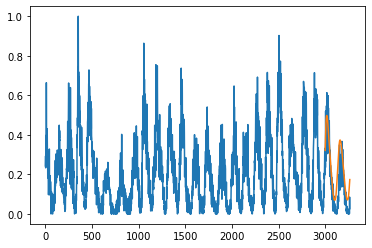

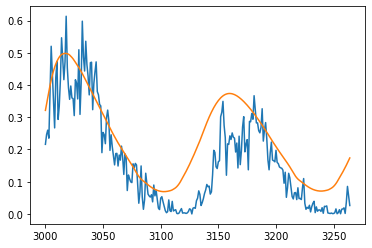

In [58]:
import matplotlib.pyplot as plt

#테스트를 위한 데이터셋 만들기
#make data for test (window_size)
test_data = []
train_y = train_y.reshape((-1))
for i in range(window_size) :
    tmp_data = train_y[-window_size*2 + i : -window_size + i]
    tmp_data = np.reshape(tmp_data, (1, window_size, 1))
    predict = model.predict(tmp_data)
    predict = predict.reshape((1))
    test_data.append(predict)

#predict
predict_list = []
for i in range(len(test_x)) :
    test_data = np.array(test_data).reshape((1, window_size, 1))
    predict = model.predict(test_data)
    predict = predict.reshape((1))
    test_data = test_data.reshape((window_size))
    predict_list.append(predict)
    test_data = np.append(test_data[1:], predict)

predict_list = np.array(predict_list)
predict_list = predict_list.reshape((-1))
times = list(range(len(data)))
plt.plot(times, data)
plt.plot(times[-len(test_x):], predict_list)
plt.show()

plt.plot(times[-len(test_x):], test_x)
plt.plot(times[-len(test_x):], predict_list)
plt.show()